<a href="https://colab.research.google.com/github/Yang-yamper/practice-for-graduation/blob/main/VGG%E3%81%AE%E5%AE%9F%E8%A3%85%EF%BC%88%E7%B1%B3%E6%B4%A5%E7%8E%84%E5%B8%AB%E3%82%B8%E3%83%A3%E3%82%B1%E5%86%99%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


# 画像ディレクトリ
IMG_DIR = '/content/drive/MyDrive/sample_data'
# バッチサイズ
BATCH_SIZE = 32
# VGG16を使用するため以下のサイズに設定
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3, )

# 訓練、検証、テストの比率
TRAIN_SIZE = 0.6
VALIDATION_SIZE = 0.2
TEST_SIZE = 0.2

# 実行毎に同一の結果が得られるようシード値を固定
RANDOM_STATE = 123

# 学習率
LEARNING_RATE = 3e-5

# エポック数
INITIAL_EPOCHS = 5

# ------------------------------------------------------------
# 1.画像とラベル取得と訓練・検証・テスト分割
# ------------------------------------------------------------
# (1) 画像読み込み
image_dataset = image_dataset_from_directory(IMG_DIR,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE
                                             )

# (2) 画像データセットをX:画像とY:クラス名で各々配列化
image_class_names = image_dataset.class_names
img_X = []
img_Y = []
for img_ds_batch in list(image_dataset.as_numpy_iterator()):
    img_X.extend(img_ds_batch[0])
    img_Y.extend(img_ds_batch[1])

img_X = np.asarray(img_X)
img_Y = np.asarray(img_Y)

# (3) 画像データの標準化
img_X = tf.keras.applications.vgg16.preprocess_input(img_X)

# (4) データセットを訓練・検証・テストに分割
# データセットを[train, (validation + test)]に分割
img_X_train, imp_X_tmp, img_Y_train, img_Y_tmp = train_test_split(
    img_X, img_Y,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=img_Y)

# (validation + test)データセットを[validation, test]に分割
VAL_TEST_SPLIT_SIZE = VALIDATION_SIZE / (VALIDATION_SIZE + TEST_SIZE)
img_X_valid, img_X_test, img_Y_valid, img_Y_test = train_test_split(
    imp_X_tmp, img_Y_tmp,
    train_size=VAL_TEST_SPLIT_SIZE,
    random_state=RANDOM_STATE,
    stratify=img_Y_tmp)

Found 290 files belonging to 6 classes.


In [3]:
# ------------------------------------------------------------
# 2.モデル構築と学習
# ------------------------------------------------------------
# (1) 転移学習のベースモデルとしてVGG16を宣言
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               input_shape=IMAGE_SHAPE,
                                               weights='imagenet')

# (2) 畳み込みベースの凍結
base_model.trainable = False

# (3) モデル構築
# Flatten(=平坦化層)追加
x = tf.keras.layers.Flatten()(base_model.output)
# FC1層追加
x = tf.keras.layers.Dense(4096, activation='relu')(x)
# FC2層追加
x = tf.keras.layers.Dense(4096, activation='relu')(x)
# 入力画像の形状
transfer_learning_inputs = base_model.inputs
# predictions層の追加
# 今回分類するクラス数を指定
image_class_num = len(image_class_names)
transfer_learning_prediction = tf.keras.layers.Dense(
                                 image_class_num, activation='softmax')(x)
# 転移学習モデル構築
transfer_learning_model = tf.keras.Model(inputs=transfer_learning_inputs,
                                         outputs=transfer_learning_prediction)

# (4) モデルのコンパイル
transfer_learning_model.compile(optimizer=
                                    tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

# (5) モデルの学習
history = transfer_learning_model.fit(img_X_train, img_Y_train,
                                      epochs=INITIAL_EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      validation_data=(img_X_valid, img_Y_valid))


58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/5
6/6 [==============================] - 127s 22s/step - loss: 6.8268 - accuracy: 0.4483 - val_loss: 0.4361 - val_accuracy: 0.9310
Epoch 2/5
6/6 [==============================] - 127s 22s/step - loss: 0.3213 - accuracy: 0.9483 - val_loss: 1.7872 - val_accuracy: 0.7759
Epoch 3/5
6/6 [==============================] - 123s 21s/step - loss: 0.0674 - accuracy: 0.9943 - val_loss: 1.3578 - val_accuracy: 0.8448
Epoch 4/5
6/6 [==============================] - 123s 21s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.0692 - val_accuracy: 0.8621
Epoch 5/5
6/6 [==============================] - 124s 21s/step - loss: 6.4446e-05 - accuracy: 1.0000 - val_loss: 0.7842 - val_accuracy: 0.8966


In [5]:
transfer_learning_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

[0.9321812391281128, 0.8620689511299133]


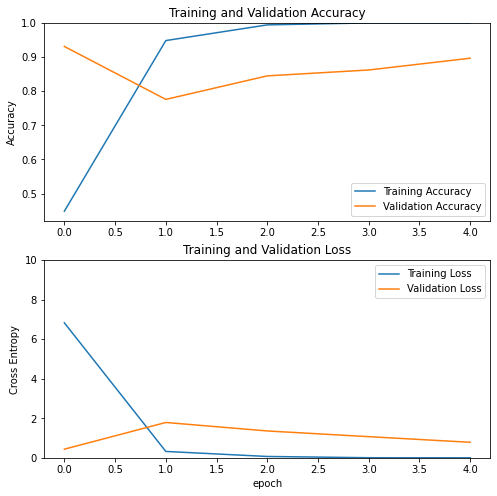

In [4]:
# ------------------------------------------------------------
# 3.画像分類と精度
# ------------------------------------------------------------
# テストデータの画像分類結果を標準出力
# [損失関数, 正解率]
print(transfer_learning_model.evaluate(img_X_test, img_Y_test, verbose=0))

# 訓練と検証
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# 正解率
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# 損失関数
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
